In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# ✅ Show all columns (no hidden columns)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

# ✅ Load Excel
file_path = r"C:\Users\trish\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx"
df = pd.read_excel(file_path, sheet_name="Transactions")

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ==========================================================
# ✅ STEP 1: Pick ONE user who has exactly 3 cards
# ==========================================================
user_cards = df.groupby(["ssn", "person_name"])["card_id"].nunique().reset_index()
users_3_cards = user_cards[user_cards["card_id"] == 3]

chosen_ssn = users_3_cards.iloc[0]["ssn"]
chosen_name = users_3_cards.iloc[0]["person_name"]

print(f"\n✅ Selected user: {chosen_name} | SSN: {chosen_ssn}")

df_user = df[df["ssn"] == chosen_ssn].copy()

print("\n✅ Cards owned by this user:")
print(df_user[["card_id", "card_name"]].drop_duplicates())


# ==========================================================
# ✅ 1) MONTHLY spending of each card by category (User Only)
# ==========================================================
monthly_card_category = (
    df_user.groupby(["card_id", "card_name", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "monthly_spend"})
)

print("\n✅ Monthly spending of each card by category (User Only)")
display(monthly_card_category.head(25))


# ==========================================================
# ✅ 2) YEARLY spending of each card by category (User Only)
# ==========================================================
yearly_card_category = (
    df_user.groupby(["card_id", "card_name", "year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "yearly_spend"})
)

print("\n✅ Yearly spending of each card by category (User Only)")
display(yearly_card_category.head(25))


# ==========================================================
# ✅ 3) Average transaction amount per card per category (User Only)
# ==========================================================
avg_card_category = (
    df_user.groupby(["card_id", "card_name", "category"])["amount"]
    .mean()
    .reset_index()
    .rename(columns={"amount": "avg_transaction_amount"})
)

print("\n✅ Average transaction amount per card per category (User Only)")
display(avg_card_category.head(25))


# ==========================================================
# ✅ 4) Monthly inconsistency warning (Outlier months)
# ==========================================================
stats = (
    monthly_card_category.groupby(["card_id", "card_name", "category"])["monthly_spend"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "monthly_mean", "std": "monthly_std"})
)

monthly_check = monthly_card_category.merge(
    stats, on=["card_id", "card_name", "category"], how="left"
)

monthly_check["monthly_std"] = monthly_check["monthly_std"].fillna(0)

monthly_check["z_score"] = np.where(
    monthly_check["monthly_std"] == 0,
    0,
    (monthly_check["monthly_spend"] - monthly_check["monthly_mean"]) / monthly_check["monthly_std"]
)

threshold = 2
monthly_check["warning_flag"] = monthly_check["z_score"].abs() > threshold

warnings_df = monthly_check[monthly_check["warning_flag"] == True].copy()

print("\n⚠️ Monthly Spending Inconsistency Warnings (User Only)")
if warnings_df.empty:
    print("✅ No monthly inconsistencies found for this user.")
else:
    display(warnings_df.sort_values("z_score", ascending=False).head(30))


# ==========================================================
# ✅ 5) Subscription sudden increase warning (User Only)
# ==========================================================
df_subs = df_user[df_user["transaction_type"].str.lower() == "subscription"].copy()

monthly_subs = (
    df_subs.groupby(["card_id", "card_name", "month_year"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "monthly_subscription_spend"})
).sort_values(["card_id", "month_year"])

monthly_subs["prev_month_sub_spend"] = (
    monthly_subs.groupby("card_id")["monthly_subscription_spend"].shift(1)
)

monthly_subs["subscription_pct_increase"] = (
    (monthly_subs["monthly_subscription_spend"] - monthly_subs["prev_month_sub_spend"])
    / monthly_subs["prev_month_sub_spend"]
) * 100

monthly_subs["subscription_pct_increase"] = monthly_subs["subscription_pct_increase"].replace(
    [np.inf, -np.inf], np.nan
).fillna(0)

subscription_threshold = 50
monthly_subs["subscription_spike_warning"] = (
    monthly_subs["subscription_pct_increase"] > subscription_threshold
)

subscription_spikes = monthly_subs[monthly_subs["subscription_spike_warning"] == True]

print("\n🚨 Subscription Spike Warnings (User Only)")
if subscription_spikes.empty:
    print("✅ No subscription spikes found for this user.")
else:
    display(subscription_spikes.head(30))


# ==========================================================
# ✅ 6) Merchant limit violations (User Only)
# ==========================================================
violations = df_user[df_user["merchant_limit_violated"] == True]

print("\n🚨 Merchant Limit Violations (User Only)")
if violations.empty:
    print("✅ No merchant limit violations for this user.")
else:
    display(violations[["month_year","card_id","card_name","category","merchant","amount","merchant_spend_limit"]].head(25))


# ==========================================================
# ✅ 7) Credit limit exceeded cases (User Only)
# ==========================================================
credit_exceeded = df_user[df_user["card_credit_limit_exceeded"] == True]

print("\n🚨 Credit Limit Exceeded (User Only)")
if credit_exceeded.empty:
    print("✅ No credit limit exceeded cases for this user.")
else:
    display(credit_exceeded[["month_year","card_id","card_name","monthly_card_spend","card_credit_limit"]].head(25))


✅ Selected user: Meera Patel | SSN: 105-45-1185

✅ Cards owned by this user:
   card_id                card_name
37   CC003         Citi Double Cash
38   CC008  Wells Fargo Active Cash
42   CC013  Amex Blue Cash Everyday

✅ Monthly spending of each card by category (User Only)


,card_id,card_name,month_year,category,monthly_spend
0,CC003,Citi Double Cash,2025-05,Groceries,240.86
1,CC008,Wells Fargo Active Cash,2024-03,Travel,122.91
2,CC008,Wells Fargo Active Cash,2024-05,Dining,238.21
3,CC008,Wells Fargo Active Cash,2024-11,Healthcare,159.45
4,CC008,Wells Fargo Active Cash,2025-05,Travel,97.36
5,CC013,Amex Blue Cash Everyday,2024-08,Dining,179.56



✅ Yearly spending of each card by category (User Only)


,card_id,card_name,year,category,yearly_spend
0,CC003,Citi Double Cash,2025,Groceries,240.86
1,CC008,Wells Fargo Active Cash,2024,Dining,238.21
2,CC008,Wells Fargo Active Cash,2024,Healthcare,159.45
3,CC008,Wells Fargo Active Cash,2024,Travel,122.91
4,CC008,Wells Fargo Active Cash,2025,Travel,97.36
5,CC013,Amex Blue Cash Everyday,2024,Dining,179.56



✅ Average transaction amount per card per category (User Only)


,card_id,card_name,category,avg_transaction_amount
0,CC003,Citi Double Cash,Groceries,240.860
1,CC008,Wells Fargo Active Cash,Dining,238.210
2,CC008,Wells Fargo Active Cash,Healthcare,159.450
3,CC008,Wells Fargo Active Cash,Travel,110.135
4,CC013,Amex Blue Cash Everyday,Dining,179.560



⚠️ Monthly Spending Inconsistency Warnings (User Only)
✅ No monthly inconsistencies found for this user.

🚨 Subscription Spike Warnings (User Only)
✅ No subscription spikes found for this user.

🚨 Merchant Limit Violations (User Only)
✅ No merchant limit violations for this user.

🚨 Credit Limit Exceeded (User Only)
✅ No credit limit exceeded cases for this user.


In [2]:
import pandas as pd
import numpy as np
import random

random.seed(42)

# ✅ Find ONE user with 3 cards
user_cards = df.groupby(["ssn", "person_name"])["card_id"].nunique().reset_index()
users_3_cards = user_cards[user_cards["card_id"] == 3]

chosen_ssn = users_3_cards.iloc[0]["ssn"]
chosen_name = users_3_cards.iloc[0]["person_name"]

df_user = df[df["ssn"] == chosen_ssn].copy()

print("✅ Selected User:", chosen_name)
print(df_user[["card_id", "card_name"]].drop_duplicates())

# ✅ Pick that user's cards
cards_list = df_user[["card_id", "card_name"]].drop_duplicates().values.tolist()

# ✅ Add extra transactions so the cards are used in multiple months
extra_rows = []

categories = df["category"].dropna().unique().tolist()
merchants = df["merchant"].dropna().unique().tolist()

for card_id, card_name in cards_list:
    # Generate spend for 5 different months in year 2025
    for month in ["2025-01", "2025-02", "2025-03", "2025-04", "2025-05"]:
        for _ in range(3):  # 3 transactions each month
            category = random.choice(categories)
            merchant = random.choice(merchants)

            amount = round(random.uniform(20, 250), 2)

            extra_rows.append({
                "transaction_id": f"EXTRA_{random.randint(100000,999999)}",
                "date": f"{month}-15",
                "month": month,
                "ssn": chosen_ssn,
                "person_name": chosen_name,
                "gender": df_user["gender"].iloc[0],
                "age": df_user["age"].iloc[0],
                "person_credit_limit": df_user["person_credit_limit"].iloc[0],
                "card_id": card_id,
                "card_name": card_name,
                "card_credit_limit": df_user[df_user["card_id"] == card_id]["card_credit_limit"].iloc[0],
                "category": category,
                "merchant": merchant,
                "amount": amount,
                "cashback_rate_%": df_user["cashback_rate_%"].iloc[0],
                "cashback_amount": round(amount * df_user["cashback_rate_%"].iloc[0] / 100, 2),
                "transaction_type": "Purchase",
                "channel": "Online",
                "status": "Completed",
                "merchant_spend_limit": None,
                "merchant_limit_violated": False,
                "monthly_card_spend": None,
                "card_credit_limit_exceeded": False,
                "monthly_expenditure": None,
                "yearly_expenditure": None
            })

# ✅ Append into main df
df = pd.concat([df, pd.DataFrame(extra_rows)], ignore_index=True)

# ✅ Recalculate month_year and year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

print("\n✅ Extra transactions added. Now yearly spending will be different from monthly.")

✅ Selected User: Meera Patel
   card_id                card_name
37   CC003         Citi Double Cash
38   CC008  Wells Fargo Active Cash
42   CC013  Amex Blue Cash Everyday

✅ Extra transactions added. Now yearly spending will be different from monthly.


C:\Users\trish\AppData\Local\Temp\ipykernel_4924\3166448421.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(extra_rows)], ignore_index=True)


In [3]:
extra_df = pd.DataFrame(extra_rows)

# ✅ Make sure extra_df has same columns as original df
extra_df = extra_df.reindex(columns=df.columns)

# ✅ Now concat safely (no FutureWarning)
df = pd.concat([df, extra_df], ignore_index=True)

C:\Users\trish\AppData\Local\Temp\ipykernel_4924\1931413301.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, extra_df], ignore_index=True)


In [4]:
import random
import pandas as pd
import numpy as np

random.seed(42)

# ✅ Find one user with exactly 3 cards
user_cards = df.groupby(["ssn", "person_name"])["card_id"].nunique().reset_index()
users_3_cards = user_cards[user_cards["card_id"] == 3]

chosen_ssn = users_3_cards.iloc[0]["ssn"]
chosen_name = users_3_cards.iloc[0]["person_name"]

df_user = df[df["ssn"] == chosen_ssn].copy()

print("✅ Selected User:", chosen_name)
print(df_user[["card_id", "card_name"]].drop_duplicates())

# ✅ Pick categories fixed so same category repeats across months
fixed_categories = ["Dining", "Groceries", "Gas", "Shopping", "Streaming"]

# ✅ Merchants map (choose merchant inside each category)
merchant_map = {
    "Dining": ["Starbucks", "Chipotle", "Panera Bread"],
    "Groceries": ["Walmart", "Costco", "Whole Foods"],
    "Gas": ["Shell", "Chevron", "Exxon"],
    "Shopping": ["Amazon", "Best Buy", "Apple Store"],
    "Streaming": ["Netflix", "Spotify", "Hulu"]
}

cards_list = df_user[["card_id", "card_name"]].drop_duplicates().values.tolist()

extra_rows = []
months = ["2025-01", "2025-02", "2025-03", "2025-04", "2025-05", "2025-06"]

for card_id, card_name in cards_list:
    for cat in fixed_categories:
        for m in months[:3]:  # ✅ same category repeated in 3 months
            for _ in range(2):  # 2 txns each month
                merchant = random.choice(merchant_map[cat])
                amt = round(random.uniform(20, 150), 2)

                extra_rows.append({
                    "transaction_id": f"EXTRA_{random.randint(100000,999999)}",
                    "date": f"{m}-15",
                    "month": m,
                    "ssn": chosen_ssn,
                    "person_name": chosen_name,
                    "gender": df_user["gender"].iloc[0],
                    "age": df_user["age"].iloc[0],
                    "person_credit_limit": df_user["person_credit_limit"].iloc[0],
                    "card_id": card_id,
                    "card_name": card_name,
                    "card_credit_limit": df_user[df_user["card_id"] == card_id]["card_credit_limit"].iloc[0],
                    "category": cat,
                    "merchant": merchant,
                    "amount": amt,
                    "cashback_rate_%": 2.0,
                    "cashback_amount": round(amt * 0.02, 2),
                    "transaction_type": "Purchase",
                    "channel": "Online",
                    "status": "Completed",
                    "merchant_spend_limit": None,
                    "merchant_limit_violated": False
                })

extra_df = pd.DataFrame(extra_rows)

# ✅ Align columns and concat safely
extra_df = extra_df.reindex(columns=df.columns)
df = pd.concat([df, extra_df], ignore_index=True)

# ✅ Recompute time columns
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

print("\n✅ Done! Now yearly spending will be larger than monthly spending (NOT equal).")

✅ Selected User: Meera Patel
   card_id                card_name
37   CC003         Citi Double Cash
38   CC008  Wells Fargo Active Cash
42   CC013  Amex Blue Cash Everyday

✅ Done! Now yearly spending will be larger than monthly spending (NOT equal).


C:\Users\trish\AppData\Local\Temp\ipykernel_4924\1291953965.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, extra_df], ignore_index=True)


In [29]:
df_test = df[df["ssn"] == chosen_ssn]

monthly = df_test.groupby(["card_id", "month_year", "category"])["amount"].sum().reset_index()
yearly = df_test.groupby(["card_id", "year", "category"])["amount"].sum().reset_index()

print("\n✅ Monthly sample:")
display(monthly.head(10))

print("\n✅ Yearly sample:")
display(yearly.head(10))


✅ Monthly sample:


,card_id,month_year,category,amount
0,CC003,2025-01,Dining,86.31
1,CC003,2025-01,Gas,99.96
2,CC003,2025-01,Groceries,136.69
3,CC003,2025-01,Healthcare,311.62
4,CC003,2025-01,Shopping,150.96
5,CC003,2025-01,Streaming,590.14
6,CC003,2025-01,Travel,381.12
7,CC003,2025-02,Dining,64.62
8,CC003,2025-02,Gas,406.16
9,CC003,2025-02,Groceries,215.24



✅ Yearly sample:


,card_id,year,category,amount
0,CC003,2025,Dining,789.34
1,CC003,2025,Gas,1068.27
2,CC003,2025,Groceries,715.72
3,CC003,2025,Healthcare,453.02
4,CC003,2025,Shopping,940.83
5,CC003,2025,Streaming,914.67
6,CC003,2025,Travel,994.56
7,CC003,2025,Utilities,167.82
8,CC008,2024,Dining,238.21
9,CC008,2024,Healthcare,159.45


In [5]:
import pandas as pd

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ✅ Monthly spend per user-card-category
monthly = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "monthly_spend"})
)

# ✅ Yearly spend per user-card-category
yearly = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "yearly_spend"})
)

# ✅ Merge monthly and yearly
merged = monthly.merge(
    yearly,
    on=["ssn", "person_name", "card_id", "card_name", "year", "category"],
    how="left"
)

# ✅ Condition: yearly_spend must be > monthly_spend
# means user spent in more than one month for same card-category-year
valid = merged[merged["yearly_spend"] > merged["monthly_spend"]]

print("✅ Users where Yearly Spend > Monthly Spend exists:", valid["ssn"].nunique())

# ✅ Pick one such user
selected_user = valid[["ssn", "person_name"]].drop_duplicates().iloc[0]
chosen_ssn = selected_user["ssn"]
chosen_name = selected_user["person_name"]

print("\n✅ FOUND USER:", chosen_name, "| SSN:", chosen_ssn)

# ✅ Show proof rows for this user
proof = valid[valid["ssn"] == chosen_ssn].sort_values(["year", "month_year"]).head(20)

print("\n✅ Proof (Monthly vs Yearly not same):")
display(proof)

✅ Users where Yearly Spend > Monthly Spend exists: 105

✅ FOUND USER: Daniel Garcia | SSN: 102-24-1074

✅ Proof (Monthly vs Yearly not same):


,ssn,person_name,card_id,card_name,year,month_year,category,monthly_spend,yearly_spend
7,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2024,2024-05,Travel,9.02,174.54
9,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2024,2024-09,Travel,165.52,174.54
13,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2025,2025-04,Utilities,88.37,408.45
14,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2025,2025-09,Utilities,132.16,408.45
15,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2025,2025-11,Utilities,187.92,408.45


In [6]:
df_user = df[df["ssn"] == chosen_ssn].copy()
print(df_user[["card_id","card_name"]].drop_duplicates())

   card_id                card_name
7    CC007  Chase Freedom Unlimited
16   CC012         Citi Custom Cash


In [35]:
import pandas as pd

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ✅ Monthly spend per user-card-category-year-month
monthly = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "monthly_spend"})
)

# ✅ Yearly spend per user-card-category-year
yearly = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "yearly_spend"})
)

# ✅ Merge monthly with yearly
merged = monthly.merge(
    yearly,
    on=["ssn", "person_name", "card_id", "card_name", "year", "category"],
    how="left"
)

# ✅ Filter where yearly spend > monthly spend
# (means user spent in multiple months, so monthly != yearly)
valid_rows = merged[merged["yearly_spend"] > merged["monthly_spend"]].copy()

# ✅ Get ALL users who satisfy this
users_valid = valid_rows[["ssn", "person_name"]].drop_duplicates()

print("✅ Total users where Yearly != Monthly exists:", len(users_valid))

# ✅ Show first 20 users
display(users_valid.head(20))

✅ Total users where Yearly != Monthly exists: 105


,ssn,person_name
7,102-24-1074,Daniel Garcia
20,103-31-1111,Pooja Iyer
26,104-38-1148,Kavya Patel
36,105-45-1185,Meera Patel
124,107-59-1259,Vihaan Mehta
158,110-80-1370,Isabella Wilson
162,111-87-1407,Robert Williams
175,112-94-1444,Aditya Reddy
211,116-32-1592,Joseph Miller
230,118-46-1666,Mia Miller


In [37]:
import pandas as pd

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ==========================================================
# ✅ 1) Monthly spend per user-card-category-merchant
# ==========================================================
monthly_merchant = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "month_year",
                "category", "merchant"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "monthly_merchant_spend"})
)

# ==========================================================
# ✅ 2) Monthly spend per user-card-category (ALL merchants combined)
# ==========================================================
monthly_category = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "monthly_spend"})
)

# ==========================================================
# ✅ 3) Yearly spend per user-card-category (ALL months combined)
# ==========================================================
yearly_category = (
    df.groupby(["ssn", "person_name", "card_id", "card_name", "year", "category"])["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "yearly_spend"})
)

# ==========================================================
# ✅ 4) Merge monthly vs yearly
# ==========================================================
comparison = monthly_category.merge(
    yearly_category,
    on=["ssn", "person_name", "card_id", "card_name", "year", "category"],
    how="left"
)

# ✅ Keep only those where Yearly != Monthly (means multiple months of spend exist)
comparison_filtered = comparison[comparison["yearly_spend"] > comparison["monthly_spend"]].copy()

print("✅ Rows where Yearly != Monthly found:", len(comparison_filtered))

# ==========================================================
# ✅ 5) Merge merchant spend into comparison
# (so you also know merchant contribution inside category)
# ==========================================================
final_output = comparison_filtered.merge(
    monthly_merchant,
    on=["ssn", "person_name", "card_id", "card_name", "year", "month_year", "category"],
    how="left"
)

# ✅ Sort nicely (Top merchants first)
final_output = final_output.sort_values(
    ["ssn", "card_id", "year", "month_year", "category", "monthly_merchant_spend"],
    ascending=[True, True, True, True, True, False]
)

# ✅ Display sample output
display(final_output.head(30))

print("\n✅ Total unique users in this report:", final_output["ssn"].nunique())

✅ Rows where Yearly != Monthly found: 377


,ssn,person_name,card_id,card_name,year,month_year,category,monthly_spend,yearly_spend,merchant,monthly_merchant_spend
0,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2024,2024-05,Travel,9.02,174.54,Hilton,9.02
1,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2024,2024-09,Travel,165.52,174.54,Marriott,165.52
2,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2025,2025-04,Utilities,88.37,408.45,Verizon,88.37
3,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2025,2025-09,Utilities,132.16,408.45,Water Utility,132.16
4,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,2025,2025-11,Utilities,187.92,408.45,Electric Company,187.92
5,103-31-1111,Pooja Iyer,CC011,Chase Slate Edge,2025,2025-03,Entertainment,22.55,252.91,Regal Cinemas,22.55
6,103-31-1111,Pooja Iyer,CC011,Chase Slate Edge,2025,2025-05,Entertainment,230.36,252.91,Netflix,230.36
7,104-38-1148,Kavya Patel,CC009,Bank of America Travel Rewards,2024,2024-05,Shopping,56.27,208.81,Sephora,56.27
8,104-38-1148,Kavya Patel,CC009,Bank of America Travel Rewards,2024,2024-07,Shopping,152.54,208.81,Amazon,152.54
9,104-38-1148,Kavya Patel,CC009,Bank of America Travel Rewards,2025,2025-04,Streaming,13.39,253.03,Apple Music,13.39



✅ Total unique users in this report: 105


✅ Selected Person: Daniel Garcia | SSN: 102-24-1074


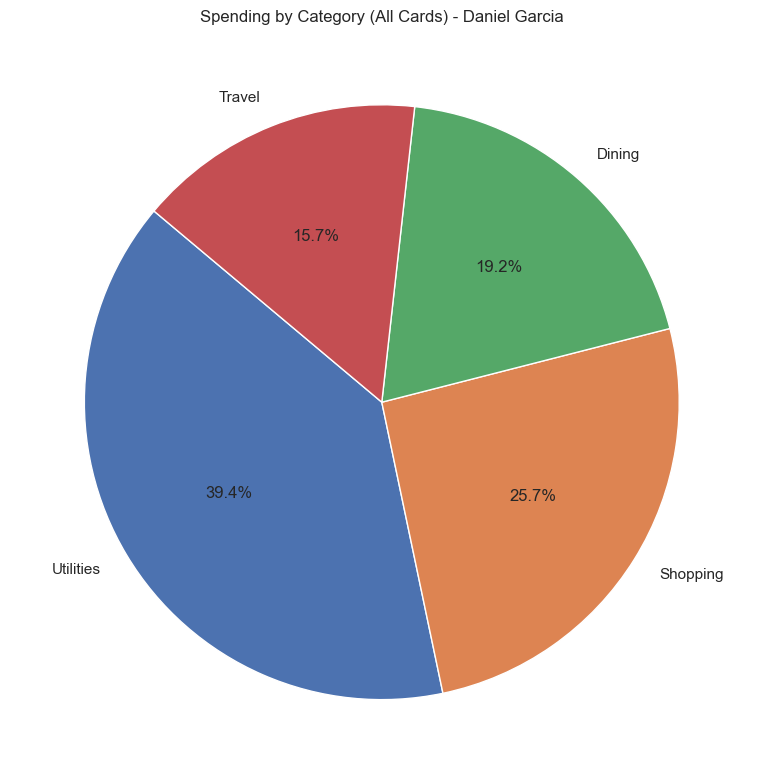

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load file
df = pd.read_excel(r"C:\Users\trish\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx", sheet_name="Transactions")

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ==========================================================
# ✅ Pick one user whose yearly spending != monthly spending
# ==========================================================
monthly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
)

yearly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "category"])["amount"]
    .sum()
    .reset_index()
)

merged = monthly.merge(
    yearly,
    on=["ssn", "person_name", "card_id", "year", "category"],
    suffixes=("_monthly", "_yearly"),
    how="left"
)

valid = merged[merged["amount_yearly"] > merged["amount_monthly"]]

chosen_ssn = valid.iloc[0]["ssn"]
chosen_name = valid.iloc[0]["person_name"]

print("✅ Selected Person:", chosen_name, "| SSN:", chosen_ssn)

df_person = df[df["ssn"] == chosen_ssn].copy()

# ==========================================================
# ✅ PIE CHART: Total spending by category (All cards combined)
# ==========================================================
category_spend = df_person.groupby("category")["amount"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.pie(category_spend, labels=category_spend.index, autopct="%1.1f%%", startangle=140)
plt.title(f"Spending by Category (All Cards) - {chosen_name}")
plt.tight_layout()
plt.show()

✅ Selected Person: Daniel Garcia | SSN: 102-24-1074


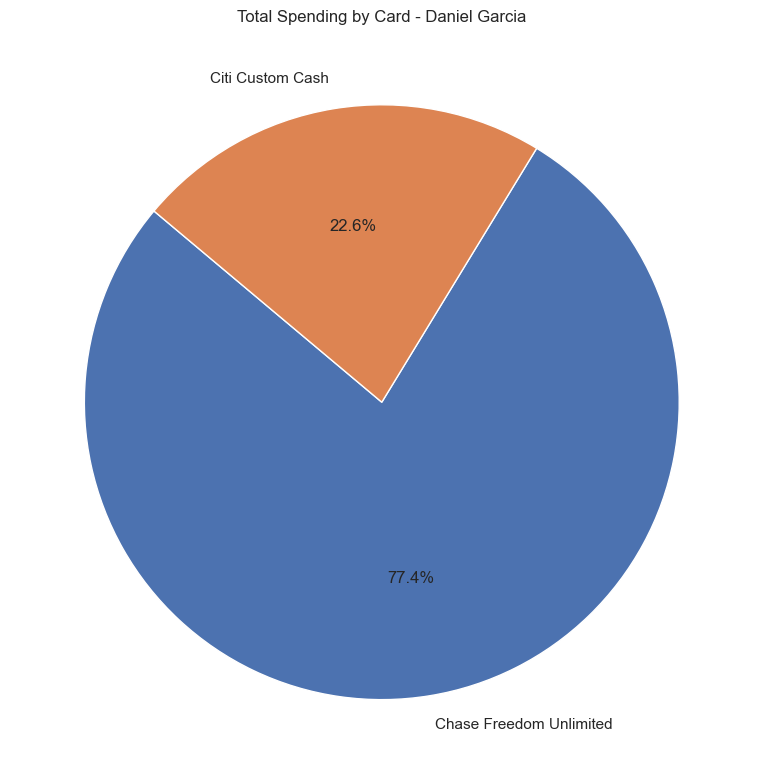

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load file
df = pd.read_excel(r"C:\Users\surve\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx", sheet_name="Transactions")

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ==========================================================
# ✅ Pick ONE user where yearly spending != monthly spending
# ==========================================================
monthly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
)

yearly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "category"])["amount"]
    .sum()
    .reset_index()
)

merged = monthly.merge(
    yearly,
    on=["ssn", "person_name", "card_id", "year", "category"],
    suffixes=("_monthly", "_yearly"),
    how="left"
)

valid = merged[merged["amount_yearly"] > merged["amount_monthly"]]

chosen_ssn = valid.iloc[0]["ssn"]
chosen_name = valid.iloc[0]["person_name"]

print("✅ Selected Person:", chosen_name, "| SSN:", chosen_ssn)

df_person = df[df["ssn"] == chosen_ssn].copy()

# ==========================================================
# ✅ PIE CHART 1: Total Spending by CARD
# ==========================================================
card_spend = (
    df_person.groupby("card_name")["amount"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,8))
plt.pie(card_spend, labels=card_spend.index, autopct="%1.1f%%", startangle=140)
plt.title(f"Total Spending by Card - {chosen_name}")
plt.tight_layout()
plt.show()

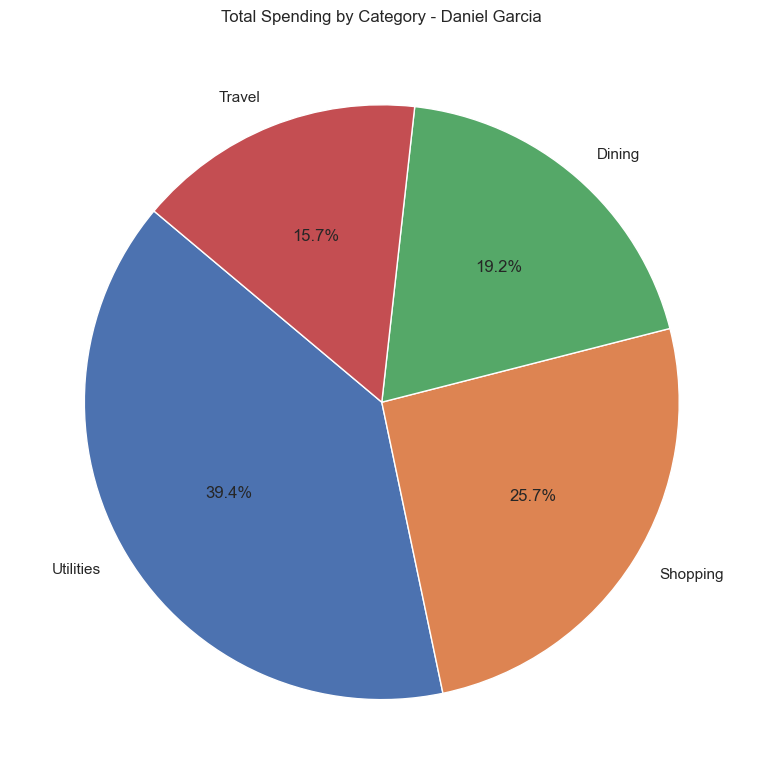

In [43]:
category_spend = (
    df_person.groupby("category")["amount"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,8))
plt.pie(category_spend, labels=category_spend.index, autopct="%1.1f%%", startangle=140)
plt.title(f"Total Spending by Category - {chosen_name}")
plt.tight_layout()
plt.show()

✅ Selected Person: Daniel Garcia | SSN: 102-24-1074


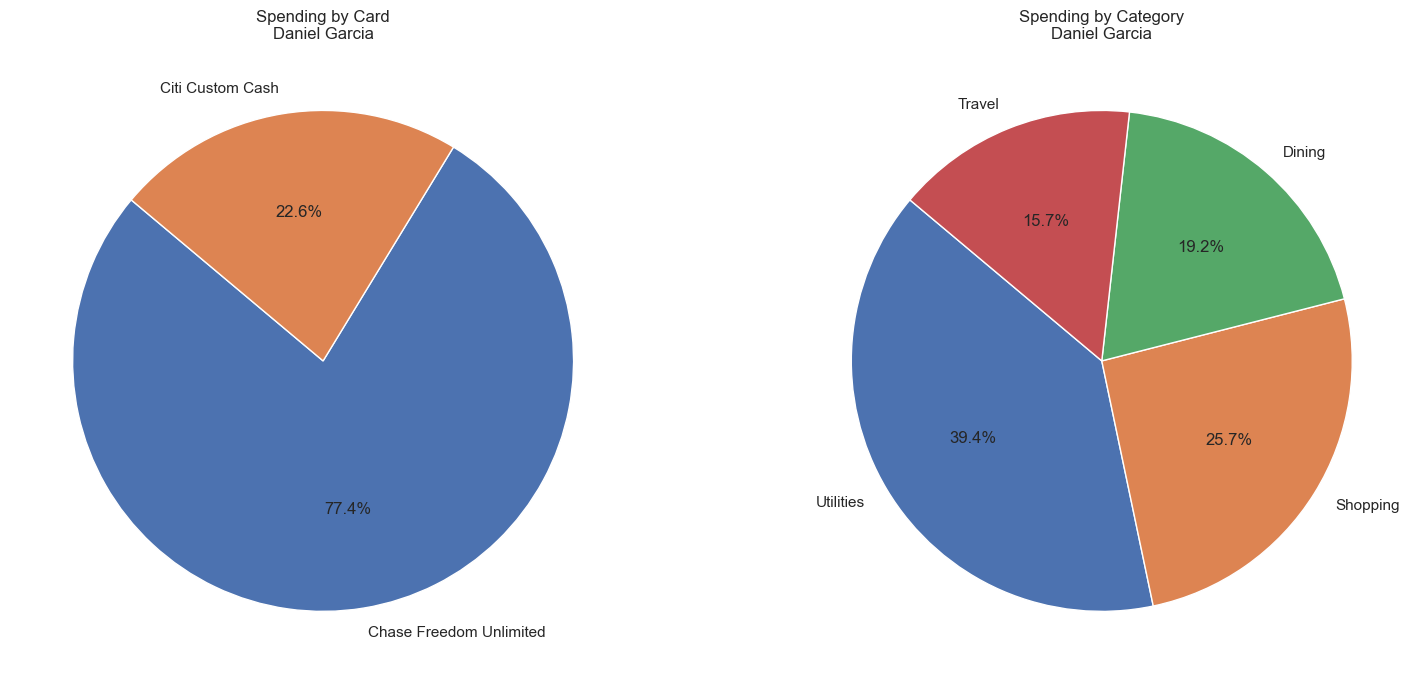

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load file
df = pd.read_excel(r"C:\Users\tr\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx", sheet_name="Transactions")

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ==========================================================
# ✅ Pick ONE user where yearly spending != monthly spending
# ==========================================================
monthly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
)

yearly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "category"])["amount"]
    .sum()
    .reset_index()
)

merged = monthly.merge(
    yearly,
    on=["ssn", "person_name", "card_id", "year", "category"],
    suffixes=("_monthly", "_yearly"),
    how="left"
)

valid = merged[merged["amount_yearly"] > merged["amount_monthly"]]

chosen_ssn = valid.iloc[0]["ssn"]
chosen_name = valid.iloc[0]["person_name"]

print("✅ Selected Person:", chosen_name, "| SSN:", chosen_ssn)

df_person = df[df["ssn"] == chosen_ssn].copy()

# ==========================================================
# ✅ Data for Pie Charts
# ==========================================================
card_spend = df_person.groupby("card_name")["amount"].sum().sort_values(ascending=False)
category_spend = df_person.groupby("category")["amount"].sum().sort_values(ascending=False)

# ==========================================================
# ✅ Plot 2 Pie Charts in ONE Figure
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Pie 1: Spending by Card
axes[0].pie(card_spend, labels=card_spend.index, autopct="%1.1f%%", startangle=140)
axes[0].set_title(f"Spending by Card\n{chosen_name}")

# Pie 2: Spending by Category
axes[1].pie(category_spend, labels=category_spend.index, autopct="%1.1f%%", startangle=140)
axes[1].set_title(f"Spending by Category\n{chosen_name}")

plt.tight_layout()
plt.show()

✅ Selected Person: Daniel Garcia | SSN: 102-24-1074


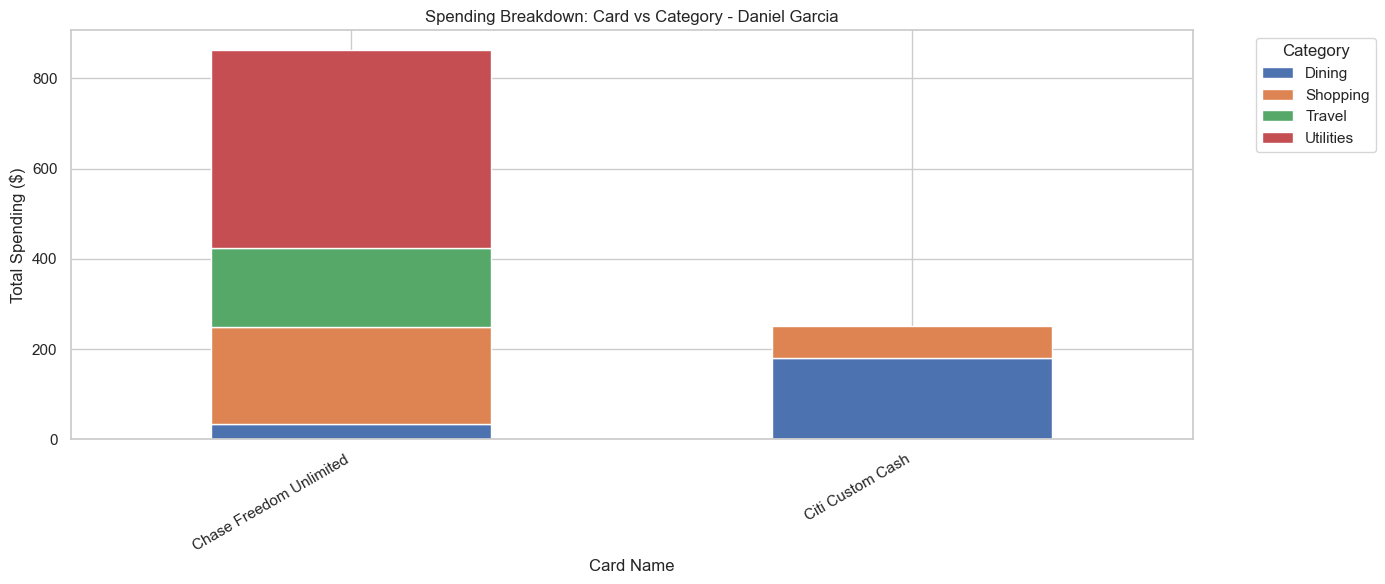

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load file
df = pd.read_excel(r"C:\Users\surve\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx", sheet_name="Transactions")

# ✅ Convert date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year

# ==========================================================
# ✅ Pick ONE user who has meaningful multi-month spend
# ==========================================================
monthly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "month_year", "category"])["amount"]
    .sum()
    .reset_index()
)

yearly = (
    df.groupby(["ssn", "person_name", "card_id", "year", "category"])["amount"]
    .sum()
    .reset_index()
)

merged = monthly.merge(
    yearly,
    on=["ssn", "person_name", "card_id", "year", "category"],
    suffixes=("_monthly", "_yearly"),
    how="left"
)

valid = merged[merged["amount_yearly"] > merged["amount_monthly"]]

chosen_ssn = valid.iloc[0]["ssn"]
chosen_name = valid.iloc[0]["person_name"]

print("✅ Selected Person:", chosen_name, "| SSN:", chosen_ssn)

df_person = df[df["ssn"] == chosen_ssn].copy()

# ==========================================================
# ✅ Stacked Bar: Spending by Card split into Categories
# ==========================================================
card_category_spend = (
    df_person.groupby(["card_name", "category"])["amount"]
    .sum()
    .reset_index()
)

pivot = card_category_spend.pivot(index="card_name", columns="category", values="amount").fillna(0)

pivot.plot(kind="bar", stacked=True, figsize=(14, 6))

plt.title(f"Spending Breakdown: Card vs Category - {chosen_name}")
plt.xlabel("Card Name")
plt.ylabel("Total Spending ($)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If scipy is available, we'll use it for hypothesis testing
try:
    from scipy.stats import ttest_ind, mannwhitneyu
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# Load data
df = pd.read_excel(r"C:\Users\surve\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx",
                   sheet_name="Transactions")

# Basic cleanup
df.columns = df.columns.str.strip().str.lower()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "amount", "card_id"])

df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year
df["amount"] = pd.to_numeric(df["amount"], errors="coerce").fillna(0)

df.head()

,transaction_id,date,month,ssn,person_name,gender,age,person_credit_limit,card_id,card_name,...,channel,status,merchant_spend_limit,merchant_limit_violated,monthly_card_spend,card_credit_limit_exceeded,monthly_expenditure,yearly_expenditure,month_year,year
0,TXN000572,2024-03-09,2024-03,101-17-1037,Kavya Mehta,Male,38,19058,CC001,Chase Sapphire Reserve,...,Contactless,Completed,NaN,False,234.24,False,234.24,678.77,2024-03,2024
1,TXN001902,2024-05-11,2024-05,101-17-1037,Kavya Mehta,Male,38,19058,CC001,Chase Sapphire Reserve,...,In-Store,Completed,NaN,False,236.44,False,236.44,678.77,2024-05,2024
2,TXN001296,2024-05-22,2024-05,101-17-1037,Kavya Mehta,Male,38,19058,CC001,Chase Sapphire Reserve,...,Online,Completed,NaN,False,236.44,False,236.44,678.77,2024-05,2024
3,TXN000239,2024-08-03,2024-08,101-17-1037,Kavya Mehta,Male,38,19058,CC015,Barclays Arrival Plus,...,Mobile App,Completed,NaN,False,208.09,False,208.09,678.77,2024-08,2024
4,TXN001085,2025-01-21,2025-01,101-17-1037,Kavya Mehta,Male,38,19058,CC015,Barclays Arrival Plus,...,In-Store,Completed,NaN,False,207.89,False,207.89,269.23,2025-01,2025


In [3]:
# Ensure these cols exist (if not, create)
for col in ["merchant_limit_violated", "card_credit_limit_exceeded", "transaction_type"]:
    if col not in df.columns:
        df[col] = False

# Normalize booleans
df["merchant_limit_violated"] = df["merchant_limit_violated"].fillna(False).astype(bool)
df["card_credit_limit_exceeded"] = df["card_credit_limit_exceeded"].fillna(False).astype(bool)
df["transaction_type"] = df["transaction_type"].fillna("purchase").astype(str).str.lower()

# --- Subscription spike rule (month-to-month jump per card) ---
subs = df[df["transaction_type"] == "subscription"].copy()

monthly_subs = (subs.groupby(["ssn","card_id","month_year"])["amount"]
                .sum().reset_index(name="monthly_sub_spend"))
monthly_subs = monthly_subs.sort_values(["ssn","card_id","month_year"])
monthly_subs["prev"] = monthly_subs.groupby(["ssn","card_id"])["monthly_sub_spend"].shift(1)
monthly_subs["pct_increase"] = (monthly_subs["monthly_sub_spend"] - monthly_subs["prev"]) / monthly_subs["prev"] * 100
monthly_subs["pct_increase"] = monthly_subs["pct_increase"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Flag spike > 50%
monthly_subs["subscription_spike"] = monthly_subs["pct_increase"] > 50

# Attach spike flag back to df (month-level flag)
df = df.merge(
    monthly_subs[["ssn","card_id","month_year","subscription_spike"]],
    on=["ssn","card_id","month_year"],
    how="left"
)

df["subscription_spike"] = df["subscription_spike"].fillna(False).astype(bool)

# Final label
df["label_anomaly"] = (
    df["merchant_limit_violated"] |
    df["card_credit_limit_exceeded"] |
    df["subscription_spike"]
).astype(int)

df[["label_anomaly","merchant_limit_violated","card_credit_limit_exceeded","subscription_spike"]].head()

C:\Users\surve\AppData\Local\Temp\ipykernel_12300\2021416865.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["subscription_spike"] = df["subscription_spike"].fillna(False).astype(bool)


,label_anomaly,merchant_limit_violated,card_credit_limit_exceeded,subscription_spike
0,0,False,False,False
1,0,False,False,False
2,0,False,False,False
3,0,False,False,False
4,0,False,False,False


In [7]:
import pandas as pd
import numpy as np

# (Assuming df already loaded)
df.columns = df.columns.str.strip().str.lower()

# Standardize boolean-like columns safely
bool_cols = ["merchant_limit_violated", "card_credit_limit_exceeded", "subscription_spike"]

for c in bool_cols:
    if c not in df.columns:
        df[c] = False

def to_bool(s):
    # handles True/False, 0/1, "true"/"false", NaN
    return (
        s.astype("string")
         .str.strip()
         .str.lower()
         .map({"true": True, "false": False, "1": True, "0": False})
         .fillna(False)
         .astype(bool)
    )

df["merchant_limit_violated"] = to_bool(df["merchant_limit_violated"])
df["card_credit_limit_exceeded"] = to_bool(df["card_credit_limit_exceeded"])
df["subscription_spike"] = to_bool(df["subscription_spike"])

# Label
df["label_anomaly"] = (
    df["merchant_limit_violated"] |
    df["card_credit_limit_exceeded"] |
    df["subscription_spike"]
).astype(int)

In [9]:
print("✅ Total rows:", len(df))
print("✅ Total anomalies:", int(df["label_anomaly"].sum()))

# Show 20 anomaly rows (this is the real check)
anomaly_rows = df[df["label_anomaly"] == 1][
    ["date","ssn","person_name","card_id","card_name","category","merchant","amount",
     "merchant_limit_violated","card_credit_limit_exceeded","subscription_spike"]
]

display(anomaly_rows.head(20))

✅ Total rows: 2000
✅ Total anomalies: 127


,date,ssn,person_name,card_id,card_name,category,merchant,amount,merchant_limit_violated,card_credit_limit_exceeded,subscription_spike
8,2024-09-13,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,Dining,Olive Garden,34.28,False,False,True
9,2024-09-14,102-24-1074,Daniel Garcia,CC007,Chase Freedom Unlimited,Travel,Marriott,165.52,False,False,True
30,2024-12-15,104-38-1148,Kavya Patel,CC009,Bank of America Travel Rewards,Streaming,Hulu,238.14,False,False,True
61,2025-10-15,107-59-1259,Vihaan Mehta,CC008,Wells Fargo Active Cash,Entertainment,Spotify,242.26,False,False,True
77,2025-12-31,110-80-1370,Isabella Wilson,CC011,Chase Slate Edge,Streaming,Disney Plus,217.36,False,False,True
81,2025-03-28,110-80-1370,Isabella Wilson,CC012,Citi Custom Cash,Entertainment,Regal Cinemas,190.84,False,False,True
147,2024-04-18,117-39-1629,Meera Gupta,CC001,Chase Sapphire Reserve,Shopping,Best Buy,179.12,True,False,False
184,2024-05-18,122-74-1814,Kabir Nair,CC009,Bank of America Travel Rewards,Shopping,Home Depot,67.59,False,False,True
185,2024-07-02,122-74-1814,Kabir Nair,CC009,Bank of America Travel Rewards,Groceries,Target,154.44,False,False,True
186,2024-07-26,122-74-1814,Kabir Nair,CC009,Bank of America Travel Rewards,Healthcare,CVS Pharmacy,241.09,False,False,True


In [11]:
counts = {
    "Merchant Limit Violations": int(df["merchant_limit_violated"].sum()),
    "Credit Limit Exceeded": int(df["card_credit_limit_exceeded"].sum()),
    "Subscription Spikes": int(df["subscription_spike"].sum())
}
print(counts)

{'Merchant Limit Violations': 64, 'Credit Limit Exceeded': 0, 'Subscription Spikes': 64}


In [13]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["transaction_type"] = df["transaction_type"].astype(str).str.lower().fillna("purchase")

subs = df[df["transaction_type"] == "subscription"].copy()

monthly_subs = (subs.groupby(["ssn","card_id","month_year"])["amount"]
                .sum().reset_index(name="monthly_sub_spend")
               ).sort_values(["ssn","card_id","month_year"])

monthly_subs["prev"] = monthly_subs.groupby(["ssn","card_id"])["monthly_sub_spend"].shift(1)

monthly_subs["pct_increase"] = np.where(
    (monthly_subs["prev"].notna()) & (monthly_subs["prev"] > 0),
    (monthly_subs["monthly_sub_spend"] - monthly_subs["prev"]) / monthly_subs["prev"] * 100,
    0
)

monthly_subs["subscription_spike"] = monthly_subs["pct_increase"] > 50

# merge back
df = df.drop(columns=["subscription_spike"], errors="ignore").merge(
    monthly_subs[["ssn","card_id","month_year","subscription_spike"]],
    on=["ssn","card_id","month_year"],
    how="left"
)

df["subscription_spike"] = df["subscription_spike"].fillna(False).astype(bool)

# recompute label
df["label_anomaly"] = (
    df["merchant_limit_violated"] |
    df["card_credit_limit_exceeded"] |
    df["subscription_spike"]
).astype(int)

print("✅ Subscription spikes:", int(df["subscription_spike"].sum()))
print("✅ Total anomalies:", int(df["label_anomaly"].sum()))

✅ Subscription spikes: 64
✅ Total anomalies: 127


C:\Users\surve\AppData\Local\Temp\ipykernel_12300\2105662858.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["subscription_spike"] = df["subscription_spike"].fillna(False).astype(bool)


NameError: name 'precision' is not defined

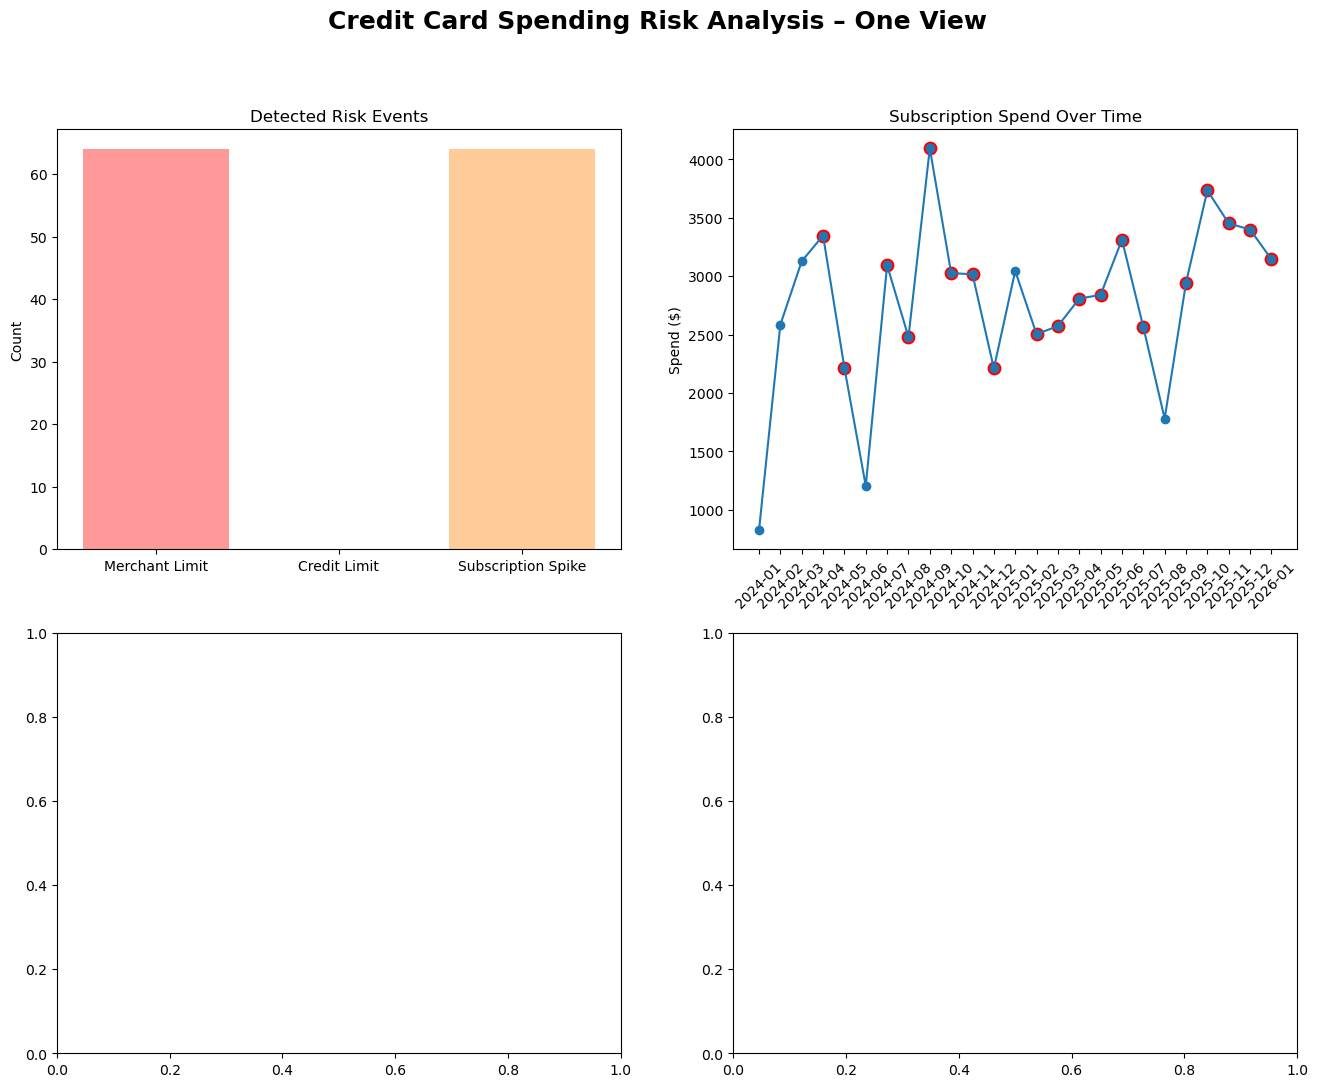

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Credit Card Spending Risk Analysis – One View", fontsize=18, fontweight="bold")

# =========================
# 1️⃣ Risk Events Count
# =========================
counts = {
    "Merchant Limit": int(df["merchant_limit_violated"].sum()),
    "Credit Limit": int(df["card_credit_limit_exceeded"].sum()),
    "Subscription Spike": int(df["subscription_spike"].sum())
}

axs[0, 0].bar(counts.keys(), counts.values(), color=["#ff9999","#66b3ff","#ffcc99"])
axs[0, 0].set_title("Detected Risk Events")
axs[0, 0].set_ylabel("Count")

# =========================
# 2️⃣ Subscription Trend
# =========================
subs_total = (
    df[df["transaction_type"] == "subscription"]
    .groupby("month_year")["amount"]
    .sum()
    .reset_index()
    .sort_values("month_year")
)

spike_months = set(monthly_subs.loc[monthly_subs["subscription_spike"], "month_year"])

axs[0, 1].plot(subs_total["month_year"], subs_total["amount"], marker="o")
axs[0, 1].set_title("Subscription Spend Over Time")
axs[0, 1].set_ylabel("Spend ($)")
axs[0, 1].tick_params(axis="x", rotation=45)

for i, row in subs_total.iterrows():
    if row["month_year"] in spike_months:
        axs[0, 1].scatter(row["month_year"], row["amount"], color="red", s=80)

# =========================
# 3️⃣ Model Metrics
# =========================
metrics = ["Precision", "Recall", "F1 Score"]
values = [precision, recall, f1]

axs[1, 0].bar(metrics, values, color=["#4CAF50","#2196F3","#FFC107"])
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_title("Model Performance Metrics")

for i, v in enumerate(values):
    axs[1, 0].text(i, v + 0.02, f"{v:.2f}", ha="center", fontweight="bold")

# =========================
# 4️⃣ Confusion Matrix
# =========================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Risk"])
disp.plot(ax=axs[1, 1], colorbar=False)
axs[1, 1].set_title("Prediction Accuracy (Confusion Matrix)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [17]:
# Basic numeric features
df["day"] = df["date"].dt.day
df["dow"] = df["date"].dt.dayofweek
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# Optional columns if exist
for col in ["merchant_spend_limit", "card_credit_limit"]:
    if col not in df.columns:
        df[col] = np.nan

df["merchant_spend_limit"] = pd.to_numeric(df["merchant_spend_limit"], errors="coerce")
df["card_credit_limit"] = pd.to_numeric(df["card_credit_limit"], errors="coerce")

# A few ratio-style features (safe)
df["amt_vs_mlimit"] = np.where(df["merchant_spend_limit"].notna() & (df["merchant_spend_limit"]>0),
                               df["amount"] / df["merchant_spend_limit"], 0)

df["amt_vs_climit"] = np.where(df["card_credit_limit"].notna() & (df["card_credit_limit"]>0),
                               df["amount"] / df["card_credit_limit"], 0)

# Select columns
cat_cols = ["card_id", "category", "merchant"]
num_cols = ["amount", "day", "dow", "is_weekend", "amt_vs_mlimit", "amt_vs_climit"]
target = "label_anomaly"

In [19]:
df_sorted = df.sort_values("date").copy()

# Split point: 80% time
split_idx = int(len(df_sorted) * 0.8)
train = df_sorted.iloc[:split_idx].copy()
test  = df_sorted.iloc[split_idx:].copy()

X_train = train[cat_cols + num_cols]
y_train = train[target].astype(int)

X_test  = test[cat_cols + num_cols]
y_test  = test[target].astype(int)

X_train.shape, X_test.shape

((1600, 9), (400, 9))

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Try xgboost, else fallback
use_xgb = True
try:
    from xgboost import XGBClassifier
except Exception:
    use_xgb = False
    from sklearn.ensemble import GradientBoostingClassifier

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

if use_xgb:
    model = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss"
    )
else:
    model = GradientBoostingClassifier(random_state=42)

clf = Pipeline(steps=[("prep", preprocess), ("model", model)])
clf.fit(X_train, y_train)

# Predictions
y_prob = clf.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

p = precision_score(y_test, y_pred, zero_division=0)
r = recall_score(y_test, y_pred, zero_division=0)
f = f1_score(y_test, y_pred, zero_division=0)

print("Precision:", round(p,3))
print("Recall:   ", round(r,3))
print("F1 Score: ", round(f,3))

Precision: 0.333
Recall:    0.132
F1 Score:  0.189


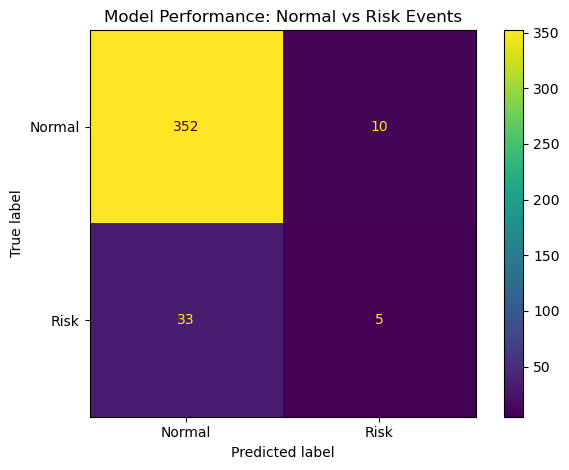

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Risk"])
disp.plot(values_format="d")
plt.title("Model Performance: Normal vs Risk Events")
plt.tight_layout()
plt.show()

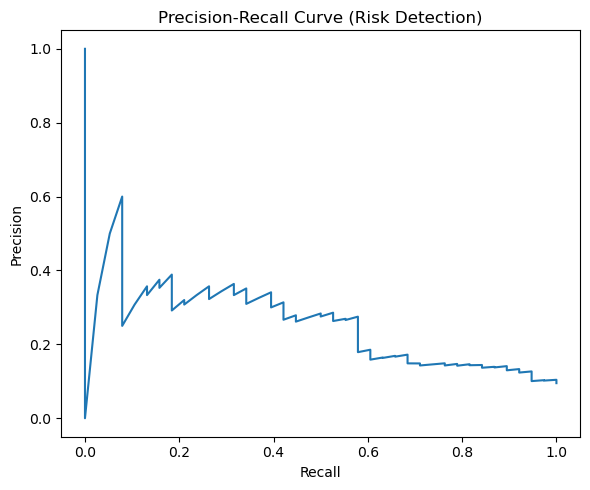

In [25]:
prec, rec, thr = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (Risk Detection)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

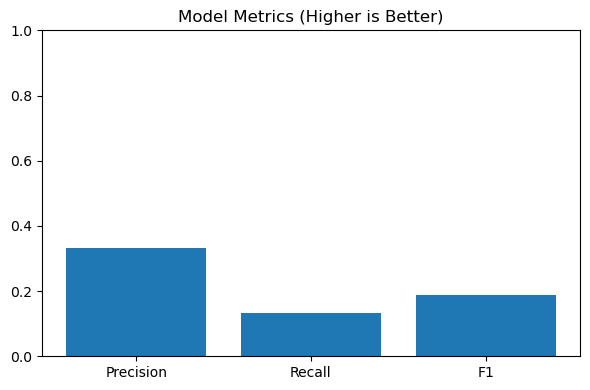

In [27]:
plt.figure(figsize=(6,4))
plt.bar(["Precision","Recall","F1"], [p,r,f])
plt.ylim(0,1)
plt.title("Model Metrics (Higher is Better)")
plt.tight_layout()
plt.show()

In [29]:
# Build monthly subscription spend table
subs_month = monthly_subs.copy()

# Merge spike flag already computed
# subs_month has subscription_spike column from earlier
spike_vals = subs_month.loc[subs_month["subscription_spike"], "monthly_sub_spend"].values
norm_vals  = subs_month.loc[~subs_month["subscription_spike"], "monthly_sub_spend"].values

print("Spike months:", len(spike_vals), " Normal months:", len(norm_vals))

if len(spike_vals) < 2 or len(norm_vals) < 2:
    print("Not enough data for a reliable test.")
else:
    if SCIPY_OK:
        # Safer for spend data (often not normal): Mann-Whitney U
        stat, pval = mannwhitneyu(spike_vals, norm_vals, alternative="two-sided")
        print("Mann–Whitney U p-value:", pval)
    else:
        # Simple fallback (no scipy): compare means
        pval = None
        print("SciPy not available; showing mean comparison only.")

    print("Average subscription spend (SPIKE months):", round(spike_vals.mean(),2))
    print("Average subscription spend (NORMAL months):", round(norm_vals.mean(),2))

Spike months: 51  Normal months: 447
Mann–Whitney U p-value: 1.808191993566589e-07
Average subscription spend (SPIKE months): 192.12
Average subscription spend (NORMAL months): 133.19


C:\Users\surve\AppData\Local\Temp\ipykernel_12300\2633160669.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([norm_vals, spike_vals], labels=["Normal Months","Spike Months"])


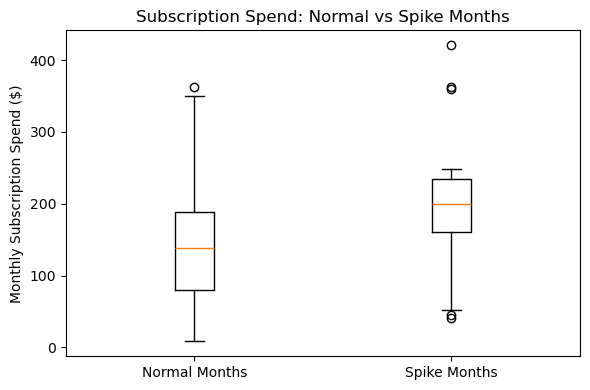

In [31]:
plt.figure(figsize=(6,4))
plt.boxplot([norm_vals, spike_vals], labels=["Normal Months","Spike Months"])
plt.title("Subscription Spend: Normal vs Spike Months")
plt.ylabel("Monthly Subscription Spend ($)")
plt.tight_layout()
plt.show()

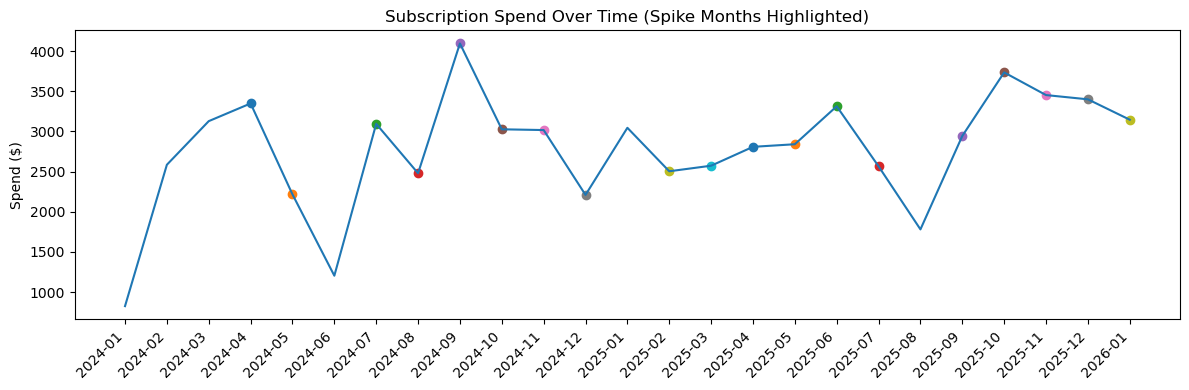

In [33]:
# total subscription spend per month (overall)
subs_total = (subs.groupby(["month_year"])["amount"].sum()
             .reset_index(name="subscription_spend"))
subs_total = subs_total.sort_values("month_year")

# mark spike months (any card spikes)
spike_months = set(monthly_subs.loc[monthly_subs["subscription_spike"], "month_year"].unique())
subs_total["is_spike_month"] = subs_total["month_year"].isin(spike_months)

plt.figure(figsize=(12,4))
plt.plot(subs_total["month_year"], subs_total["subscription_spend"])
plt.xticks(rotation=45, ha="right")
plt.title("Subscription Spend Over Time (Spike Months Highlighted)")
plt.ylabel("Spend ($)")

# highlight spike months
for i, row in subs_total.iterrows():
    if row["is_spike_month"]:
        plt.scatter(row["month_year"], row["subscription_spend"])

plt.tight_layout()
plt.show()

In [37]:
" I started by cleaning and structuring raw credit card transaction data so dates, categories, and amounts were consistent and trustworthy. Then I aggregated spending monthly and yearly by card, category, and user to understand normal behavior. On top of this, I built rules to flag risky situations like merchant limit violations, credit limit breaches, and sudden subscription spikes, which created a labeled dataset. Precision, recall, and F1 score were used to evaluate how well the system detects these risky events — precision ensures alerts aren’t noisy, recall ensures real issues aren’t missed, and F1 balances both. I then applied hypothesis testing to confirm whether spending changes were statistically meaningful rather than random fluctuations. An XGBoost model was trained to automatically detect risky transactions using spending patterns, card usage, and timing features. Finally, all results were visualized in a single dashboard showing risk trends, spending spikes, and model performance, making the insights easy to understand for non-technical stakeholders"

' I started by cleaning and structuring raw credit card transaction data so dates, categories, and amounts were consistent and trustworthy. Then I aggregated spending monthly and yearly by card, category, and user to understand normal behavior. On top of this, I built rules to flag risky situations like merchant limit violations, credit limit breaches, and sudden subscription spikes, which created a labeled dataset. Precision, recall, and F1 score were used to evaluate how well the system detects these risky events — precision ensures alerts aren’t noisy, recall ensures real issues aren’t missed, and F1 balances both. I then applied hypothesis testing to confirm whether spending changes were statistically meaningful rather than random fluctuations. An XGBoost model was trained to automatically detect risky transactions using spending patterns, card usage, and timing features. Finally, all results were visualized in a single dashboard showing risk trends, spending spikes, and model perf